In [3]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

from scipy.integrate import simpson
from scipy.interpolate import interp1d

from src.utils import *
from src.rotor import Rotor
from src.bemt import bemt

dpi = 350   #Images resolutions
save_images = True  # flag to save plots

# 1. Blade Project
### 1.1 Validate Geometry generation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


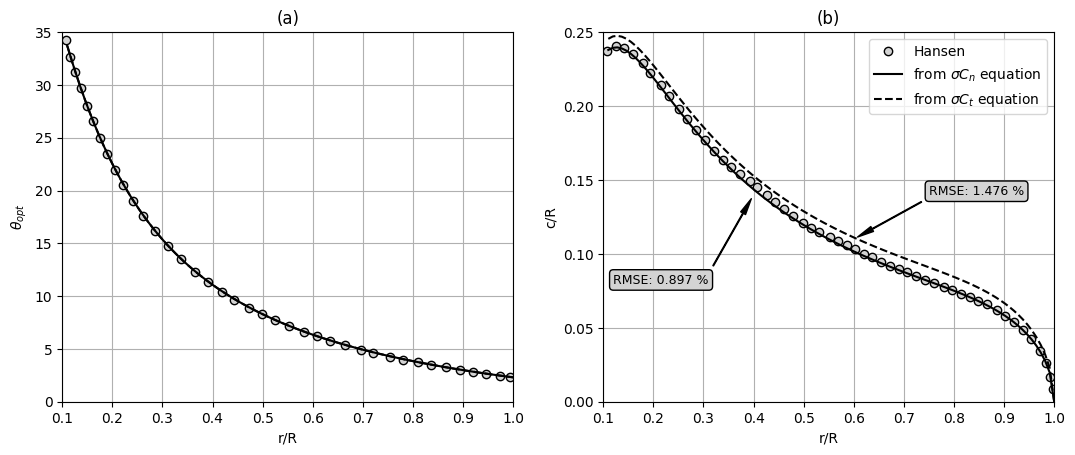

In [4]:
rotor = Rotor(number_of_blades=3, number_of_sections=100, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012, tip_correction_model='Prandtl')
rotor2 = Rotor(number_of_blades=3, number_of_sections=100, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012, tip_correction_model='Prandtl')

rotor.blade_design(r0_R=0.11, plot=False, solidity='Cn', filter_invalid_solidity=False)
rotor2.blade_design(r0_R=0.11, plot=False, solidity='Ct', filter_invalid_solidity=False)

chord_hansen_validate = np.loadtxt(validate_path.joinpath('chord_distribution_Hansen.dat'))
pitch_hansen_validate = np.loadtxt(validate_path.joinpath('pitch_distribution_Hansen.dat'))


# Compute Error
code_Cn = interp1d(rotor.sections['r_R'], rotor.sections['c_R'], kind='cubic')
code_Ct = interp1d(rotor2.sections['r_R'], rotor2.sections['c_R'], kind='cubic')
hansen = interp1d(chord_hansen_validate[:,0], chord_hansen_validate[:,1], kind='cubic')
error_Cn = (code_Cn(rotor.sections['r_R'][:-1]) - hansen(rotor.sections['r_R'][:-1]))**2
error_Ct = (code_Ct(rotor2.sections['r_R'][:-1]) - hansen(rotor2.sections['r_R'][:-1]))**2

error_Cn = np.sqrt(np.sum(error_Cn)/len(error_Cn)) * 100
error_Ct = np.sqrt(np.sum(error_Ct)/len(error_Ct)) * 100

# Pitch Angle Distribution
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12.8, 4.8))

ax1.plot(pitch_hansen_validate[:,0], pitch_hansen_validate[:,1],'o', color = 'lightgray', markeredgecolor='black', label = 'Hansen')
ax1.plot(rotor.sections['r_R'], rotor.sections['theta_opt'], 'k', label = r'from $\sigma C_n$ equation')
ax1.plot(rotor2.sections['r_R'], rotor2.sections['theta_opt'], 'k--', label = r'from $\sigma C_t$ equation')

ax1.set_title('(a)')
ax1.set_xlabel('r/R')
ax1.set_ylabel(r'$\theta_{opt}$')
ax1.set_ylim(0,35)
ax1.set_xlim(0.1, 1)

# ax1.legend()
ax1.grid()

# Chord Distribution
# plt.figure(figsize=(6.4, 4.8))
ax2.plot(chord_hansen_validate[:,0], chord_hansen_validate[:,1],'o',color='lightgray', markeredgecolor='black', label = 'Hansen')
ax2.plot(rotor.sections['r_R'], rotor.sections['c_R']*rotor.sections['tip_correction'], 'k', label = r'from $\sigma C_n$ equation')
ax2.plot(rotor2.sections['r_R'], rotor2.sections['c_R']*rotor2.sections['tip_correction'], 'k--', label = r'from $\sigma C_t$ equation')

# Adicionar a seta apontando para a primeira curva
arrow_width = 0.5
arrow_head_width = 4
ax2.annotate(f'RMSE: {error_Cn:.3f} %', 
             xy=(0.4, 0.14),  # Posição da ponta da seta (x, y) no gráfico
             xytext=(0.12, 0.08),  # Posição do texto (x, y) no gráfico
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width),
             fontsize=9, bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3'))

# Adicionar a seta apontando para a segunda curva
ax2.annotate(f'RMSE: {error_Ct:.3f} %', 
             xy=(0.6, 0.11),  # Posição da ponta da seta (x, y) no gráfico
             xytext=(0.75, 0.14),  # Posição do texto (x, y) no gráfico
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width),
             fontsize=9, bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3') )

ax2.set_title('(b)')
ax2.set_xlabel('r/R')
ax2.set_ylabel('c/R')
ax2.set_ylim(0,0.25)
ax2.set_xlim(0.1, 1)

ax2.legend(loc = 1)
ax2.grid()
if save_images:
    fig.savefig(image_path.joinpath('pitch_and_chord_distribution_validate.eps'), format='eps', dpi = dpi)
plt.show()


### 1.2 Validate numerical relationships between $a$, $a'$ and $x$ 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


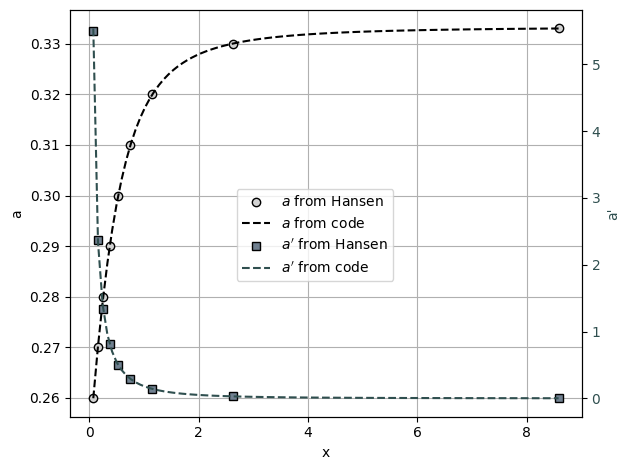

In [5]:
a, a_line, x= np.loadtxt(validate_path.joinpath('numerical_relationships_data.txt'), unpack=True)
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=8.58, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)
rotor.blade_design(r0_R=0.0085, plot=False, filter_invalid_solidity=False, solidity='Cl')

# Criando a figura e o eixo
fig, ax1 = plt.subplots()

# Plotando a em função de x
ax1.set_xlabel('x')
ax1.set_ylabel('a', color='black')
ax1.plot(x, a, 'o', color='gray', markerfacecolor = 'lightgray', markeredgecolor='black', label=r"$a$ from Hansen")
ax1.plot(rotor.sections['x'], rotor.sections['a'], 'k--', label =r"$a$ from code")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Criando um segundo eixo y para a' (compartilha o mesmo eixo x)
ax2 = ax1.twinx()
ax2.set_ylabel("a'", color='darkslategrey')
ax2.plot(x, a_line, 's', color='slategrey', markeredgecolor='black', label=r"$a'$ from Hansen")
ax2.plot(rotor.sections['x'], rotor.sections['a_line'], '--', color = 'darkslategrey', label = r"$a'$ from code")
ax2.tick_params(axis='y', labelcolor='darkslategrey')

# Exibindo o gráfico
fig.legend(loc = 'center')
fig.tight_layout()
if save_images:
    plt.savefig(image_path.joinpath('numerical_relationships.eps'), format = 'eps', dpi = dpi)
plt.show()

### 1.3 Validate $C_P$ and $C_T$ curve for Optimum Blade design

In [6]:
TSR = np.arange(2, 10.25, 0.25)

CP = np.zeros((len(TSR), 2))
CT = np.zeros((len(TSR), 2))
sections_used = np.zeros(len(TSR))
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=2, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)

for i, tsr in enumerate(TSR):
    rotor.tip_speed_ratio = tsr
    
    rotor.blade_design(r0_R=0.05, plot=False, filter_invalid_solidity=False)
    CP[i, 0] = rotor.CP_opt
    CT[i, 0] = rotor.CT_opt
    
    rotor.blade_design(r0_R=0.05, plot=False)
    CP[i, 1] = rotor.CP_opt
    CT[i, 1] = rotor.CT_opt
    sections_used[i] = rotor.number_of_sections_useful/rotor.number_of_sections
    print(f'Sections used: {rotor.number_of_sections_useful/rotor.number_of_sections * 100:.2f} %') 

Warning TSR = 2.0: solidity > 1 - This Points will be ignored
Sections used: 66.00 %
Warning TSR = 2.25: solidity > 1 - This Points will be ignored
Sections used: 71.00 %
Warning TSR = 2.5: solidity > 1 - This Points will be ignored
Sections used: 74.00 %
Warning TSR = 2.75: solidity > 1 - This Points will be ignored
Sections used: 77.00 %
Warning TSR = 3.0: solidity > 1 - This Points will be ignored
Sections used: 79.00 %
Warning TSR = 3.25: solidity > 1 - This Points will be ignored
Sections used: 81.00 %
Warning TSR = 3.5: solidity > 1 - This Points will be ignored
Sections used: 83.00 %
Warning TSR = 3.75: solidity > 1 - This Points will be ignored
Sections used: 84.00 %
Warning TSR = 4.0: solidity > 1 - This Points will be ignored
Sections used: 86.00 %
Warning TSR = 4.25: solidity > 1 - This Points will be ignored
Sections used: 87.00 %
Warning TSR = 4.5: solidity > 1 - This Points will be ignored
Sections used: 88.00 %
Warning TSR = 4.75: solidity > 1 - This Points will be ignor

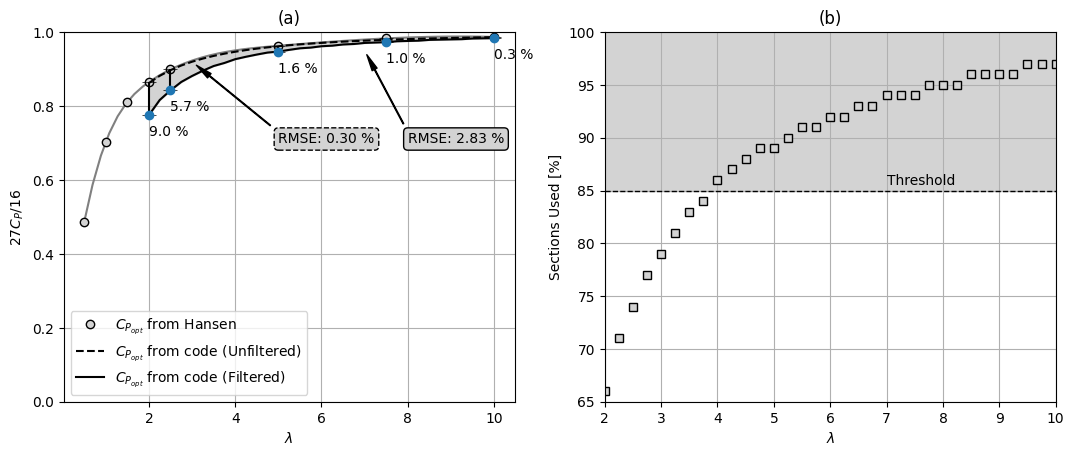

In [7]:
hansen_data = np.loadtxt(validate_path.joinpath('betz_limit_data.txt'))
hansen_interp = interp1d(hansen_data[:,0], hansen_data[:,1], kind='cubic')
tsr = np.linspace(hansen_data[0, 0], hansen_data[-1, 0])

CP_corr = 27*CP/16
code_interp_without_filter = interp1d(TSR, CP_corr[:, 0], kind='cubic')
code_interp_with_filter = interp1d(TSR, CP_corr[:, 1], kind='cubic')

# Cálculo do erro RMS
interpolated_hansen = hansen_interp(TSR)
error_rms_no_filter = np.sqrt(np.mean((interpolated_hansen - CP_corr[:, 0])**2))
error_rms_filter = np.sqrt(np.mean((interpolated_hansen - CP_corr[:, 1])**2))

# Cálculo do erro entre alguns pontos
points_to_errors = hansen_data[hansen_data[:,0] >= 2, 0]
error_rel_without_filter = np.abs(hansen_interp(points_to_errors) - code_interp_without_filter(points_to_errors))
error_rel_with_filter = np.abs(hansen_interp(points_to_errors) - code_interp_with_filter(points_to_errors))

yerr_without_filter = [np.zeros_like(error_rel_without_filter), error_rel_without_filter]
yerr_with_filter = [np.zeros_like(error_rel_with_filter), error_rel_with_filter]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(tsr, hansen_interp(tsr), '-', color = 'gray', markerfacecolor = 'lightgray', markeredgecolor='black')
ax1.plot(hansen_data[:,0], hansen_data[:,1], 'o', color = 'gray', markerfacecolor = 'lightgray', markeredgecolor='black', label = '$C_{P_{opt}}$ from Hansen')

ax1.plot(TSR, CP_corr[:, 0], 'k--', label = '$C_{P_{opt}}$ from code (Unfiltered)')
ax1.plot(TSR, CP_corr[:, 1], 'k', label = '$C_{P_{opt}}$ from code (Filtered)')

ax1.annotate(f'RMSE: {error_rms_no_filter*100:.2f} %', 
             xy=(3, 0.92),
             xytext=(5, 0.7), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width),
             fontsize=10, color='black', bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3', linestyle = '--') )

ax1.annotate(f'RMSE: {error_rms_filter*100:.2f} %', 
             xy = (7,0.95),
             xytext=(8, 0.7),
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width), 
             fontsize=10, color='black', bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3') )

# Exibindo erros em alguns pontos
for i in range(len(points_to_errors)): 
    # plt.annotate(f'{error_rel_without_filter[i]*100:.1f} %', (points_to_errors[i], code_interp_without_filter(points_to_errors[i])), textcoords="offset points", xytext=(0,-15), ha='left', color='black')
    ax1.annotate(f'{error_rel_with_filter[i]*100:.1f} %', (points_to_errors[i], code_interp_with_filter(points_to_errors[i])), textcoords="offset points", xytext=(0,-15), ha='left', color='black')
# plt.fill_between(TSR, CP_corr[:, 0], interpolated_hansen, color='lightgray')
ax1.fill_between(TSR, CP_corr[:, 1], interpolated_hansen, color='lightgray')

# plt.errorbar(points_to_errors, code_interp_without_filter(points_to_errors) , yerr=yerr_without_filter, fmt='o', ecolor='black', capsize=5, uplims=False, capthick=0.5)
ax1.errorbar(points_to_errors, code_interp_with_filter(points_to_errors) , yerr=yerr_with_filter, fmt='o', ecolor='black', capsize=5, uplims=False, capthick=0.5)

ax1.set_title('(a)')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$27C_P/16$')
ax1.set_ylim(0,1)

ax1.grid()
ax1.legend()

ax2.plot(TSR, sections_used*100, 's', color = 'lightgray', markeredgecolor = 'black')
ax2.axhline(85, color = 'black', linestyle = '--', linewidth = 1)
ax2.fill_between(TSR, [85]*len(TSR), [100]*len(TSR), color = 'lightgray')
ax2.annotate("Threshold", xy = (7, 85.5), color = 'black')
ax2.set_title('(b)')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel('Sections Used [%]')
ax2.set_xlim(2, 10)
ax2.set_ylim(65, 100)
ax2.grid()

if save_images:
    fig.savefig(image_path.joinpath('validate_cp_and_sections_used_percent.pdf'), format= 'pdf', dpi = dpi)
plt.show()

### 1.4 Coefficients Extrapolation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


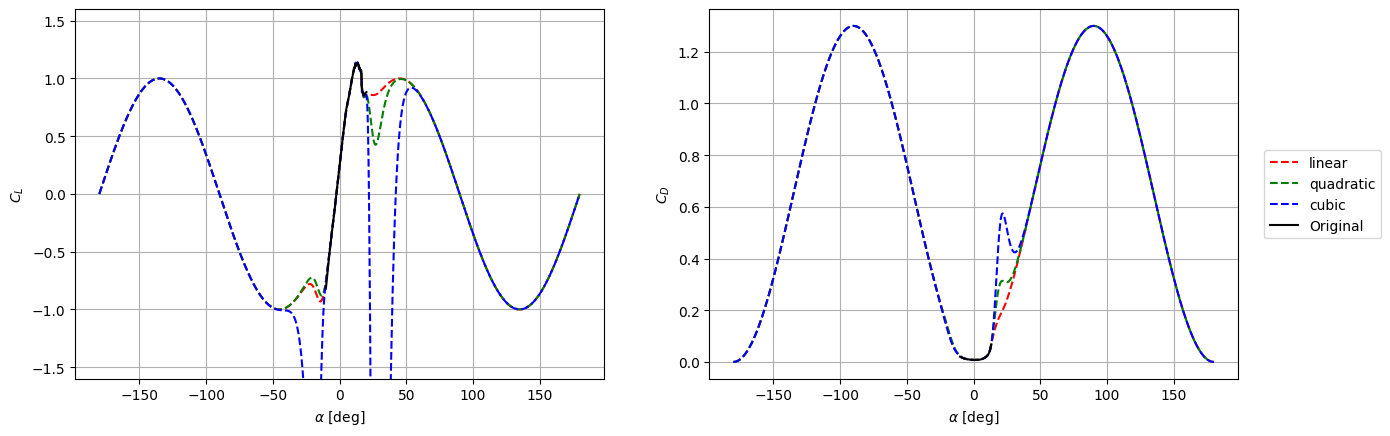

In [8]:
airfoil_name = 's834'
c_lift_drag = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_drg.txt'))
c_lift = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_lft.txt'))

re_drg = list(c_lift_drag.keys())[-1]
re_lft = list(c_lift.keys())[-2:]

Cd = c_lift_drag[re_drg][0][:, 2]
alpha_cd = c_lift_drag[re_drg][0][:, 0]

Cl = np.concatenate([c_lift[re][0][:,1] for re in re_lft])  
alpha_cl = np.concatenate([c_lift[re][0][:,0] for re in re_lft])  

arg = np.argsort(alpha_cl)
alpha_cl = np.sort(alpha_cl)
Cl = Cl[arg]

Cl_mat = np.concatenate((Cl.reshape(-1,1), alpha_cl.reshape(-1,1)), axis = 1)
Cd_mat = np.concatenate((Cd.reshape(-1,1), alpha_cd.reshape(-1,1)), axis = 1)

df_extra_linear = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='linear')
df_extra_quadratic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='quadratic')
df_extra_cubic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='cubic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 4.8])

# ax1.plot(df_extra['alpha'],  df_extra['Cl'], 'r--', label = 'Extrapolation')
ax1.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cl'], 'r--',  label = 'linear')
ax1.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cl'], 'g--',  label = 'quadratic')
ax1.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cl'], 'b--',  label = 'cubic')
ax1.plot(alpha_cl,  Cl, 'k',  label = 'Original')

ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'$C_L$')
# ax1.set_xlim([-45, 45])
ax1.set_ylim([-1.6, 1.6])
# ax1.legend()
ax1.grid()

# ax2.plot(df_extra['alpha'],  df_extra['Cd'], 'r--', label = 'Extrapolation')
ax2.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cd'], 'r--')
ax2.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cd'], 'g--')
ax2.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cd'], 'b--')
ax2.plot(alpha_cd,  Cd, 'k')

ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.set_ylabel(r'$C_D$')
ax2.grid()

fig.legend(bbox_to_anchor=(1, 0.6))
if save_images:
    fig.savefig(image_path.joinpath('interp_effect.eps'), format = 'eps', bbox_inches = 'tight', dpi = 300)
plt.show()

### 1.5 Smooth transition function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


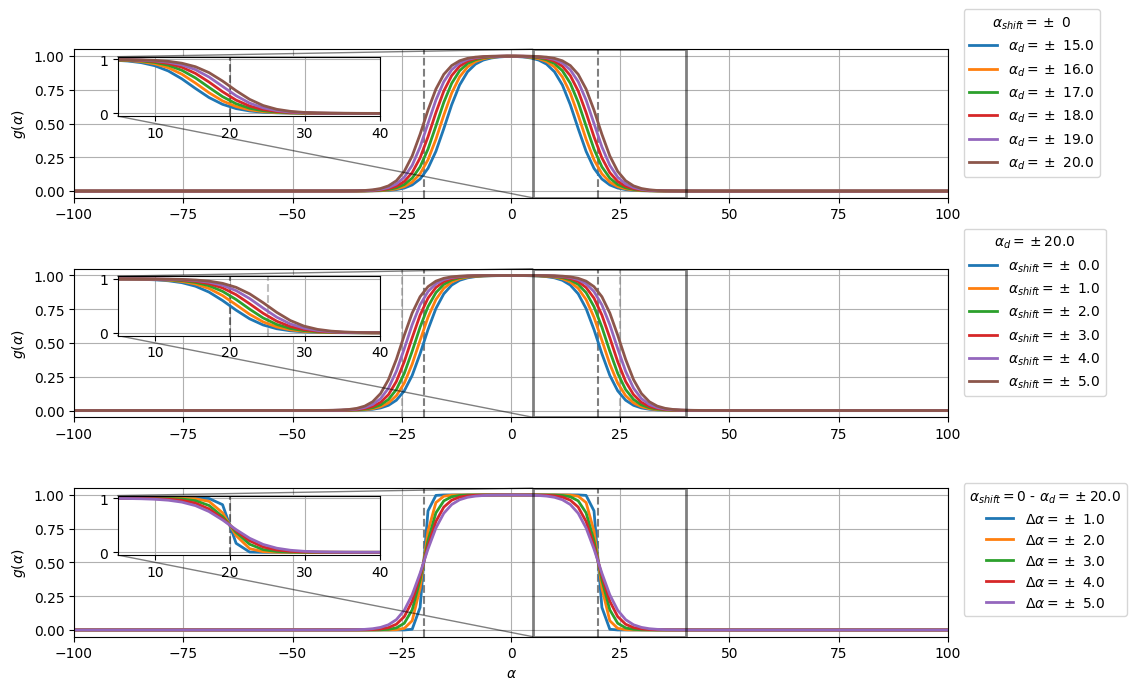

In [9]:
alpha_d = np.deg2rad(20)
alpha_shift = np.deg2rad(5)
delta_alpha = np.deg2rad(5)
alpha = np.linspace(-np.pi, np.pi, 200)


alpha_d_vec = np.deg2rad(np.arange(15, 21))
alpha_shift_vec = np.deg2rad(np.arange(0,6))
delta_alpha_vec = np.deg2rad(np.arange(1, 6))
alpha_vec = np.linspace(-np.pi, np.pi, 200)

g = lambda alpha, alpha_d = alpha_d, alpha_shift = alpha_shift, delta_alpha = delta_alpha: 0.5*(1+np.tanh((alpha_d + alpha_shift  - np.abs(alpha))/delta_alpha))

fig, axis = plt.subplots(3, 1, figsize = [10, 7])
fig.tight_layout(pad=3.0)
# fig.suptitle('Smooth Transition Function')
for i, ax in enumerate(axis):
    
    # zoomed plot
    axins = ax.inset_axes([0.05, 0.55, 0.3, 0.4])
    
    # Vertical Lines
    ax.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    ax.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    
    axins.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    axins.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    if i == 1:
        ax.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        ax.axvline(-np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
    
        axins.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        axins.axvline(-np.rad2deg(alpha_d +alpha_shift), linestyle='--', alpha = 0.5, color='gray')


    # Effect of change parameter in smooth transition function
    
    if i == 0:
        for alpha_d in alpha_d_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_d = alpha_d, alpha_shift=0), linewidth=2, label=r'$\alpha_d = \pm$ ' + f'{np.rad2deg(alpha_d):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_d=alpha_d, alpha_shift=0), linewidth=2)
            # ax.set_title('Smooth Transition function')
            title = r'$\alpha_{shift} = \pm$ 0'
    elif i == 1:
        for alpha_shift in alpha_shift_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift = alpha_shift), linewidth=2, label=r'$\alpha_{shift} = \pm$ ' + f'{np.rad2deg(alpha_shift):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=alpha_shift), linewidth=2)
            title = r'$\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    elif i == 2:
        for delta_alpha in delta_alpha_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha = delta_alpha), linewidth=2, label=r'$\Delta \alpha = \pm$ ' + f'{np.rad2deg(delta_alpha):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha=delta_alpha), linewidth=2)
            ax.set_xlabel(r'$\alpha$')
            title = r'$\alpha_{shift} = 0$ - $\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    # else:
    #     ax.plot(np.rad2deg(alpha), g(alpha), linewidth=2, color='black', label=r'$g(\alpha)$')


    ax.set_ylabel(r'$g(\alpha)$')
    # ax.set_xticks(np.arange(-180,190,10))
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.set_xlim([-100, 100])
    ax.legend(title = title, bbox_to_anchor=(1.01, 0.095))
    ax.grid()

    axins.set_xlim(5, 40)
    axins.grid()

    ax.indicate_inset_zoom(axins, linewidth=2, edgecolor="black")
if save_images:
    fig.savefig(image_path.joinpath('transition_function.eps'), format='eps', bbox_inches='tight', dpi = 300)
plt.show()


# 2. BEMT
### 2.1 Validate BEMT with simple test of Hansen

In [10]:
from IPython.display import display, Markdown

rotor_test1 = Rotor.load('hansen_test_rotor1.json')
rotor_test2 = Rotor.load('hansen_test_rotor2.json')
rotor_test3 = Rotor.load('hansen_test_rotor3.json')

results1 = bemt(rotor=rotor_test1, TSR=[rotor_test1.tip_speed_ratio], iter=500, tol=1e-8, tip_correction_model='Prandtl', boundary_conditions=False)
results2 = bemt(rotor=rotor_test2, TSR=[rotor_test2.tip_speed_ratio], iter=500, tol=1e-8, tip_correction_model='Prandtl', boundary_conditions=False)
results3 = bemt(rotor=rotor_test3, TSR=[rotor_test3.tip_speed_ratio], iter=500, tol=1e-8, tip_correction_model='Prandtl', boundary_conditions=False)


test1 = pd.DataFrame({
    'a': [rotor_test1.sections['a'][0], results1.a[0,0]],
    'a_line': [rotor_test1.sections['a_line'][0], results1.a_line[0,0]],
    'Ct': [rotor_test1.sections['Ct'][0], results1.dCt[0,0]],
    'Cn': [rotor_test1.sections['Cn'][0], results1.dCn[0,0]],
    'phi': [rotor_test1.sections['phi'][0], results1.phi[0,0]]
}, index=['Hansen', 'BEMT'])


test2 = pd.DataFrame({
    'a': [rotor_test2.sections['a'][0], results2.a[0,0]],
    'a_line': [rotor_test2.sections['a_line'][0], results2.a_line[0,0]],
    'Ct': [rotor_test2.sections['Ct'][0], results2.dCt[0,0]],
    'Cn': [rotor_test2.sections['Cn'][0], results2.dCn[0,0]],
    'phi': [rotor_test2.sections['phi'][0], results2.phi[0,0]]
}, index=['Hansen', 'BEMT'])

test3 = pd.DataFrame({
    'a': [rotor_test3.sections['a'][0], results3.a[0,0]],
    'a_line': [rotor_test3.sections['a_line'][0], results3.a_line[0,0]],
    'Ct': [rotor_test3.sections['Ct'][0], results3.dCt[0,0]],
    'Cn': [rotor_test3.sections['Cn'][0], results3.dCn[0,0]],
    'phi': [rotor_test3.sections['phi'][0], results3.phi[0,0]]
}, index=['Hansen', 'BEMT'])

test1.loc['Error (%)'] = np.abs(test1.loc['Hansen'] - test1.loc['BEMT'])/test1.loc['Hansen'] *100
test2.loc['Error (%)'] = np.abs(test2.loc['Hansen'] - test2.loc['BEMT'])/test2.loc['Hansen'] *100
test3.loc['Error (%)'] = np.abs(test3.loc['Hansen'] - test3.loc['BEMT'])/test3.loc['Hansen'] *100

display(Markdown("### Test 1"))
display(test1.round(4))
display(Markdown("### Test 2"))
display(test2.round(4))
display(Markdown("### Test 3"))
display(test3.round(4))

### Test 1

,a,a_line,Ct,Cn,phi
Hansen,0.0880,0.0010,0.0467,0.4979,0.1135
BEMT,0.0861,0.0010,0.0468,0.4979,0.1137
Error (%),2.1803,1.2409,0.2376,0.0087,0.2073


### Test 2

,a,a_line,Ct,Cn,phi
Hansen,0.1900,0.0020,0.0398,0.4984,0.1008
BEMT,0.1956,0.0020,0.0400,0.4985,0.1001
Error (%),2.9402,1.7806,0.5032,0.0213,0.6816


### Test 3

,a,a_line,Ct,Cn,phi
Hansen,0.3700,0.0030,0.0292,0.4990,0.0784
BEMT,0.3673,0.0027,0.0294,0.4992,0.0788
Error (%),0.7196,8.5206,0.5460,0.0469,0.4464


### 2.2 Convergence Analysis

In [11]:
import time

TSR = np.arange(4, 10.25, 0.25)
n_sections = np.arange(20, 220, 20)

CP = np.zeros((len(TSR), len(n_sections)))
CT = np.zeros((len(TSR), len(n_sections)))
t = np.zeros(len(n_sections))

rotor = Rotor(number_of_blades=2, number_of_sections=n_sections[0], tip_speed_ratio=8, airfoil_name='s834', tip_correction_model='Prandtl')
rotor.load_airfoil_prop(plot=False)
for n, n_section in enumerate(n_sections):
    text = f'n_sections = {n_section}'
    print(f'{text:-^40}')
    rotor.number_of_sections = n_section
    rotor.blade_design(r0_R=0.1, plot=False)
    start = time.time()
    results = bemt(rotor=rotor, TSR=TSR, iter=500, tol=1e-3, tip_correction_model='Prandtl', damping_factor=0.1, 
                   initial_guess=(rotor.sections['a'].to_numpy()[1:-1], rotor.sections['a_line'].to_numpy()[1:-1]) )
    end = time.time()
    
    CP[:, n] = results.CP
    CT[:, n] = results.CT
    t[n] = end - start
    
    print(f'Elapsed time: {end - start:.2f} s')

------------n_sections = 20-------------
Elapsed time: 0.92 s
------------n_sections = 40-------------
Elapsed time: 1.48 s
------------n_sections = 60-------------
Elapsed time: 2.50 s
------------n_sections = 80-------------
Elapsed time: 3.11 s
------------n_sections = 100------------
Elapsed time: 7.93 s
------------n_sections = 120------------
Elapsed time: 13.98 s
------------n_sections = 140------------
Elapsed time: 16.60 s
------------n_sections = 160------------
Elapsed time: 21.53 s
------------n_sections = 180------------
Elapsed time: 25.27 s
------------n_sections = 200------------
Elapsed time: 31.35 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


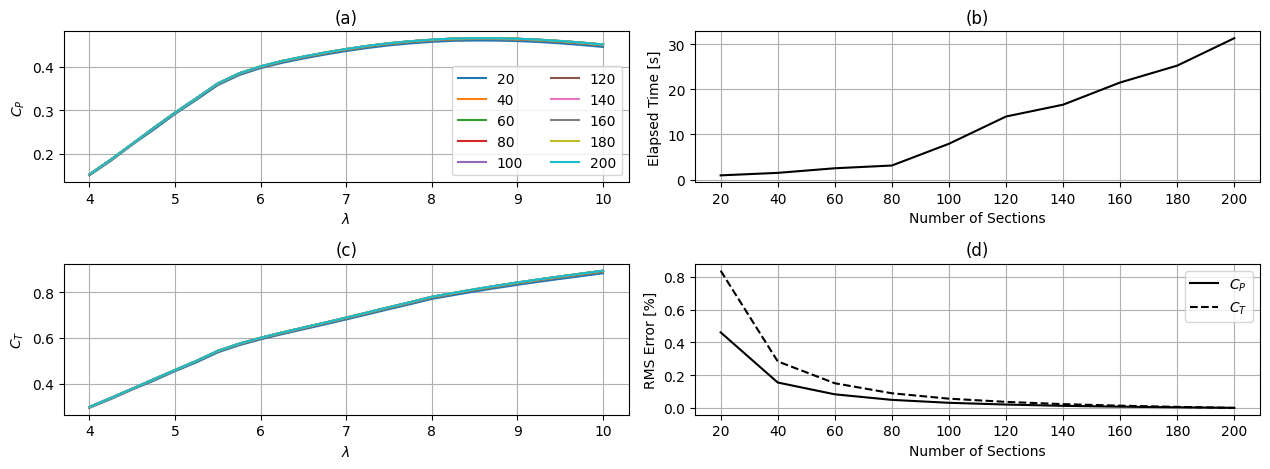

In [12]:
error_rms_CP = (CP - CP[:,-1].reshape(-1,1).repeat(10, axis=1))**2
error_rms_CP = np.sqrt(np.sum(error_rms_CP, axis=0)/len(TSR))

error_rms_CT = (CT - CT[:,-1].reshape(-1,1).repeat(10, axis=1))**2
error_rms_CT = np.sqrt(np.sum(error_rms_CT, axis=0)/len(TSR))

fig = plt.figure(figsize = [12.8, 4.8])
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

for n in range(len(n_sections)):
    ax1.plot(TSR, CP[:, n], label=f'{n_sections[n]}')
    ax2.plot(TSR, CT[:, n])

ax1.set_title('(a)')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$C_P$')
ax1.legend(loc = 'lower right', ncol = 2 )
ax1.grid()

ax2.set_title('(c)')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$C_T$')
ax2.grid()

ax3.plot(n_sections, t, 'k')
ax3.set_xticks(n_sections)
ax3.grid()
ax3.set_title('(b)')
ax3.set_xlabel('Number of Sections')
ax3.set_ylabel('Elapsed Time [s]')

ax4.plot(n_sections, error_rms_CP *100, 'k', label = r'$C_P$')
ax4.plot(n_sections, error_rms_CT *100, 'k--', label = r'$C_T$')
ax4.set_xticks(n_sections)
ax4.legend()
ax4.grid()
ax4.set_title('(d)')
ax4.set_xlabel('Number of Sections')
ax4.set_ylabel('RMS Error [%]')

plt.tight_layout()
if save_images:
    fig.savefig(image_path.joinpath('convergence_analysis.eps'), format = 'eps', dpi = dpi)
plt.show()

### 2.3 Validate BEMT with a Optimum Glaurt Rotor

In [13]:
n_sections = 80

TSR = np.arange(4, 10.15, 0.15)

CP = np.zeros((len(TSR), 2))
CT = np.zeros((len(TSR), 2))
sections_used = np.zeros(len(TSR))
rotor = Rotor(number_of_blades=2, number_of_sections=n_sections, tip_speed_ratio=4, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)

for i, tsr in enumerate(TSR):
    rotor.tip_speed_ratio = tsr    
    rotor.blade_design(r0_R=0.1, plot=False)
    sections_used[i] = rotor.number_of_sections_useful/rotor.number_of_sections
    
    # Without Drag losses and tip correction
    results = bemt(rotor=rotor, TSR=tsr, iter=500, tol=1e-3, tip_correction_model=None, Cd_null=True)
    
    CP[i, 0] = rotor.CP_opt
    CT[i, 0] = rotor.CT_opt
    
    CP[i, 1] = results.CP[0]
    CT[i, 1] = results.CT[0]

Warning TSR = 4.0: solidity > 1 - This Points will be ignored
Warning TSR = 4.15: solidity > 1 - This Points will be ignored
Warning TSR = 4.300000000000001: solidity > 1 - This Points will be ignored
Warning TSR = 4.450000000000001: solidity > 1 - This Points will be ignored
Warning TSR = 4.600000000000001: solidity > 1 - This Points will be ignored
Warning TSR = 4.750000000000002: solidity > 1 - This Points will be ignored
Warning TSR = 4.900000000000002: solidity > 1 - This Points will be ignored
Warning TSR = 5.0500000000000025: solidity > 1 - This Points will be ignored
Warning TSR = 5.200000000000003: solidity > 1 - This Points will be ignored
Warning TSR = 5.350000000000003: solidity > 1 - This Points will be ignored
Warning TSR = 5.5000000000000036: solidity > 1 - This Points will be ignored
Warning TSR = 5.650000000000004: solidity > 1 - This Points will be ignored
Warning TSR = 5.800000000000004: solidity > 1 - This Points will be ignored
Warning TSR = 5.950000000000005: soli

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


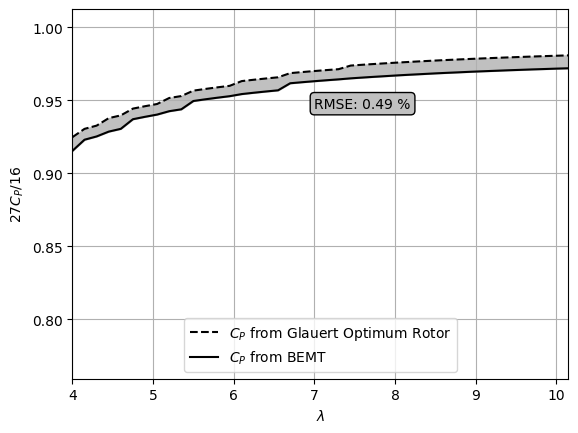

In [14]:
error = np.sqrt(np.sum((CP[:,0] - CP[:,1])**2)/len(CP[:,0])) 
plt.figure(figsize=(6.4, 4.8))
plt.plot(TSR, 27*CP[:,0]/16, 'k--', label = r'$C_{P}$ from Glauert Optimum Rotor')
plt.plot(TSR, 27*CP[:,1]/16, 'k', label = r'$C_P$ from BEMT')
plt.fill_between(TSR, 27*CP[:,0]/16, 27*CP[:,1]/16, color = 'silver')

arrow_width = 0.5
arrow_head_width = 4
plt.annotate(f'RMSE: {error*100:.2f} %', 
             xy = (7,27*0.56/16),
            #  xytext=(8, 0.54),
            #  arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width), 
             fontsize=10, color='black', bbox=dict(facecolor='silver', boxstyle = 'round, pad=0.3') )



plt.xlabel(r'$\lambda$')
plt.ylabel(r'$27C_P/16$')

ylim = 27*np.array([0.45, 0.6])/16
plt.ylim(ylim)
plt.xlim(TSR[0], TSR[-1])

plt.grid()
plt.legend(loc = 8)
if save_images:
    plt.savefig(image_path.joinpath('comparison_CP_from_bemt_and_from_glauert.eps'), format = 'eps', dpi = dpi)
plt.show()

### 2.4 Comparison between two models of rotors (with B = 2 and B = 3)

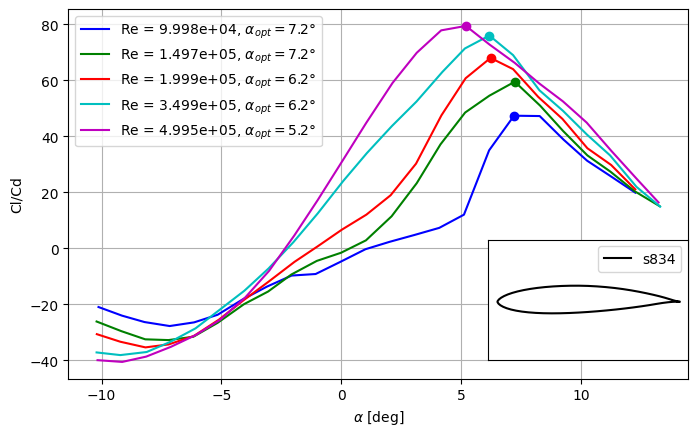

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


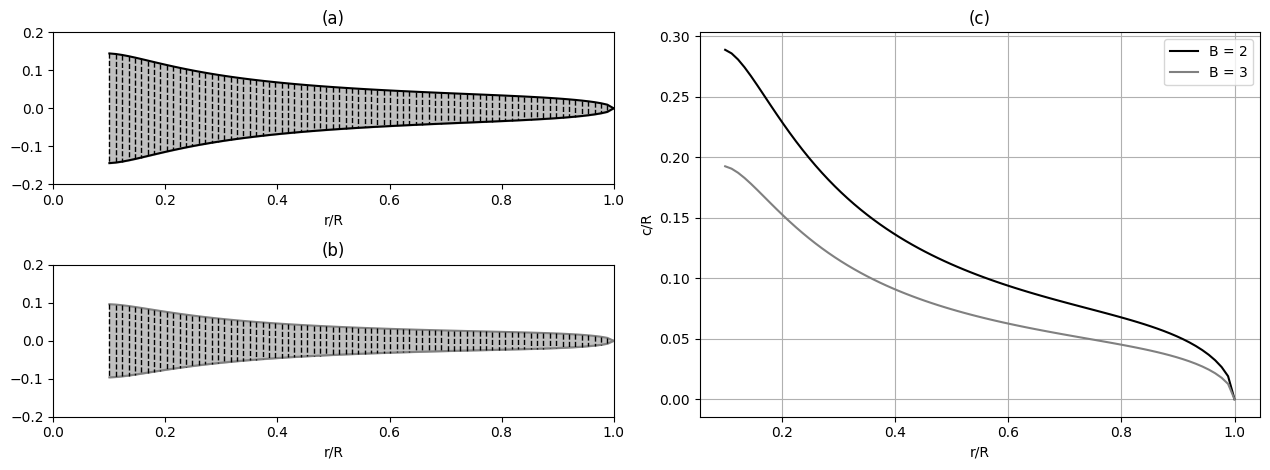

Cl opt = 0.7470
Cd opt = 0.0094
alpha opt = 5.2000


In [15]:
n_sections = 80
rotor_B2 = Rotor(number_of_blades=2, number_of_sections=n_sections, tip_speed_ratio=8, tip_correction_model='Prandtl',  airfoil_name='s834')
fig_LD = rotor_B2.load_airfoil_prop(plot=True)
rotor_B2.blade_design(r0_R=0.1, plot=False, filter_invalid_solidity=True)
le_B2, te_B2 = rotor_B2.blade_geometry()

rotor_B3 = Rotor(number_of_blades=3, number_of_sections=n_sections, tip_speed_ratio=8, tip_correction_model='Prandtl',  airfoil_name='s834')
rotor_B3.load_airfoil_prop(plot=False)
rotor_B3.blade_design(r0_R=0.1, plot=False, filter_invalid_solidity=True)
le_B3, te_B3 = rotor_B3.blade_geometry()

r_R_B2 = rotor_B2.sections['r_R'].to_numpy()
c_R_B2 = rotor_B2.sections['c_R'].to_numpy() * rotor_B2.sections['tip_correction'].to_numpy() 
r_R_B3 = rotor_B3.sections['r_R'].to_numpy()
c_R_B3 = rotor_B3.sections['c_R'].to_numpy() * rotor_B2.sections['tip_correction'].to_numpy() 

fig = plt.figure(figsize=(12.8, 4.8))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

ax1.plot(le_B2[:,0], le_B2[:,1], 'k' )
ax1.plot(te_B2[:,0], te_B2[:,1], 'k' )
ax1.fill_between(le_B2[:,0], le_B2[:,1], te_B2[:,1], color = 'silver')
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.2, 0.2)

ax1.set_xlabel('r/R')
ax1.set_title('(a)')


ax2.plot(le_B3[:,0], le_B3[:,1], 'gray' )
ax2.plot(te_B3[:,0], te_B3[:,1], 'gray' )
ax2.fill_between(le_B3[:,0], le_B3[:,1], te_B3[:,1], color = 'silver')
ax2.set_xlim(0, 1)
ax2.set_ylim(-0.2, 0.2)

ax2.set_xlabel('r/R')
ax2.set_title('(b)')

for i in range(0,len(le_B2[:,0]), 1):
    ax1.plot([le_B2[i,0], te_B2[i,0]], [le_B2[i,1], te_B2[i,1]], 'k--', linewidth = 1)
    ax2.plot([le_B3[i,0], te_B3[i,0]], [le_B3[i,1], te_B3[i,1]], 'k--', linewidth = 1)
    
ax3.plot(r_R_B2, c_R_B2, 'k', label = 'B = 2')  
ax3.plot(r_R_B3, c_R_B3, 'gray', label = 'B = 3')

ax3.set_title('(c)')
ax3.set_xlabel('r/R')
ax3.set_ylabel('c/R')

ax3.grid()
ax3.legend()

plt.tight_layout()
if save_images:
    fig.savefig(image_path.joinpath('comparison_between_two_rotors.eps'), format = 'eps', dpi = dpi)
    fig_LD.savefig(image_path.joinpath('airfoil_LD_alpha.eps'), format = 'eps', dpi = dpi)
plt.show()

print(f'Cl opt = {rotor_B2.Cl_opt:.4f}')
print(f'Cd opt = {rotor_B2.Cd_opt:.4f}')
print(f'alpha opt = {rotor_B2.alpha_opt:.4f}')

In [16]:
results_B2 = bemt(rotor=rotor_B2, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl',
                  iter=200, tol=1e-3, display=True, damping_factor=0.1,
                  initial_guess=(rotor_B2.sections['a'].to_numpy()[1:-1], rotor_B2.sections['a_line'].to_numpy()[1:-1]))


TSR: 4.0
-> Iteration: 65, Converged: True
TSR: 4.25
-> Iteration: 66, Converged: True
TSR: 4.5
-> Iteration: 71, Converged: True
TSR: 4.75
-> Iteration: 73, Converged: True
TSR: 5.0
-> Iteration: 75, Converged: True
TSR: 5.25
-> Iteration: 86, Converged: True
TSR: 5.5
-> Iteration: 67, Converged: True
TSR: 5.75
-> Iteration: 57, Converged: True
TSR: 6.0
-> Iteration: 55, Converged: True
TSR: 6.25
-> Iteration: 54, Converged: True
TSR: 6.5
-> Iteration: 53, Converged: True
TSR: 6.75
-> Iteration: 53, Converged: True
TSR: 7.0
-> Iteration: 52, Converged: True
TSR: 7.25
-> Iteration: 50, Converged: True
TSR: 7.5
-> Iteration: 46, Converged: True
TSR: 7.75
-> Iteration: 39, Converged: True
TSR: 8.0
-> Iteration: 14, Converged: True
TSR: 8.25
-> Iteration: 22, Converged: True
TSR: 8.5
-> Iteration: 34, Converged: True
TSR: 8.75
-> Iteration: 41, Converged: True
TSR: 9.0
-> Iteration: 45, Converged: True
TSR: 9.25
-> Iteration: 49, Converged: True
TSR: 9.5
-> Iteration: 52, Converged: True


In [17]:
results_B3 = bemt(rotor=rotor_B3, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl', 
                  iter=200, tol=1e-3, display=True, damping_factor=0.1,
                  initial_guess=(rotor_B3.sections['a'].to_numpy()[1:-1], rotor_B3.sections['a_line'].to_numpy()[1:-1]))

TSR: 4.0
-> Iteration: 65, Converged: True
TSR: 4.25
-> Iteration: 67, Converged: True
TSR: 4.5
-> Iteration: 68, Converged: True
TSR: 4.75
-> Iteration: 74, Converged: True
TSR: 5.0
-> Iteration: 84, Converged: True
TSR: 5.25
-> Iteration: 84, Converged: True
TSR: 5.5
-> Iteration: 67, Converged: True
TSR: 5.75
-> Iteration: 58, Converged: True
TSR: 6.0
-> Iteration: 56, Converged: True
TSR: 6.25
-> Iteration: 55, Converged: True
TSR: 6.5
-> Iteration: 54, Converged: True
TSR: 6.75
-> Iteration: 54, Converged: True
TSR: 7.0
-> Iteration: 53, Converged: True
TSR: 7.25
-> Iteration: 51, Converged: True
TSR: 7.5
-> Iteration: 47, Converged: True
TSR: 7.75
-> Iteration: 40, Converged: True
TSR: 8.0
-> Iteration: 15, Converged: True
TSR: 8.25
-> Iteration: 23, Converged: True
TSR: 8.5
-> Iteration: 35, Converged: True
TSR: 8.75
-> Iteration: 43, Converged: True
TSR: 9.0
-> Iteration: 48, Converged: True
TSR: 9.25
-> Iteration: 51, Converged: True
TSR: 9.5
-> Iteration: 54, Converged: True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


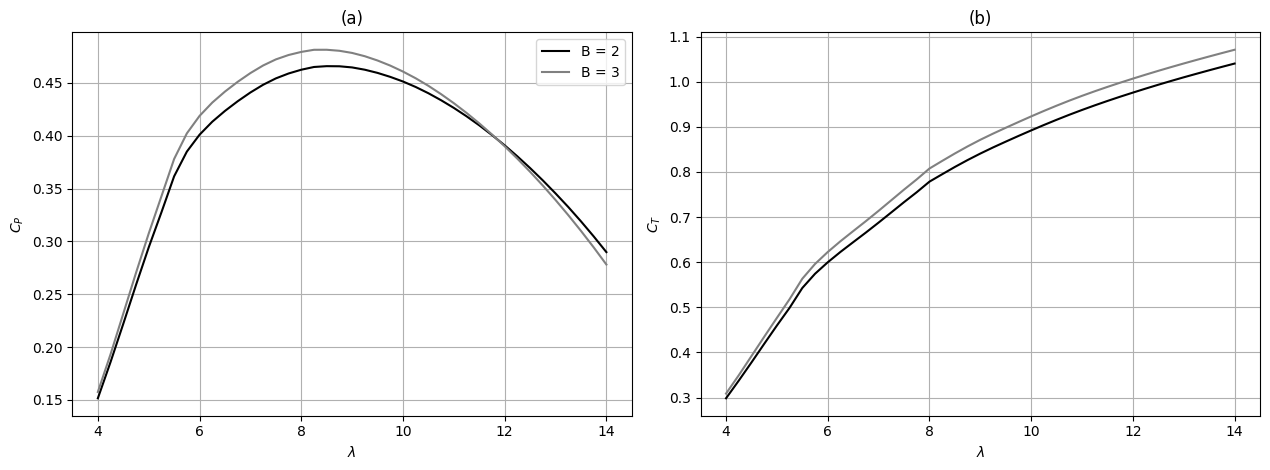

Increase CP max = 3.33%
Increase CT = 3.68%


In [29]:
TSR = results_B2.TSR

CP_B2 = results_B2.CP
CP_B3 = results_B3.CP
CT_B2 = results_B2.CT
CT_B3 = results_B3.CT

fig = plt.figure(figsize=(12.8, 4.8))
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(TSR, CP_B2, 'k', label = 'B = 2')
ax1.plot(TSR, CP_B3, 'gray', label = 'B = 3')

ax1.set_title('(a)')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$C_P$')
ax1.grid()
ax1.legend()

ax2.plot(TSR, CT_B2, 'k', label = 'B = 2')
ax2.plot(TSR, CT_B3, 'gray', label = 'B = 3')

ax2.set_title('(b)')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$C_T$')
ax2.grid()
# ax2.legend()

plt.tight_layout()
if save_images:
    fig.savefig(image_path.joinpath('comparison_between_two_rotors_CP_and_CT.eps'), format = 'eps', dpi = dpi)
plt.show()

max_pos_B2 = np.argmax(CP_B2)
max_pos_B3 = np.argmax(CP_B3) 
print(f'Increase CP max = {(CP_B3[max_pos_B3] - CP_B2[max_pos_B2])/CP_B2[max_pos_B2] * 100 :.2f}%')
print(f'Increase CT = {(CT_B3[max_pos_B3] - CT_B2[max_pos_B2])/CT_B2[max_pos_B2] * 100 :.2f}%')


### 2.5 Effect of 3D corrections

In [19]:
results_B2_3D_Snel = bemt(rotor=rotor_B2, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl',
                  iter=200, tol=1e-3, display=False, damping_factor=0.1,
                  initial_guess=(rotor_B2.sections['a'].to_numpy()[1:-1], rotor_B2.sections['a_line'].to_numpy()[1:-1]), 
                  threeD_correction_model='Snel')

results_B2_3D_Lindenburg = bemt(rotor=rotor_B2, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl',
                  iter=200, tol=1e-3, display=False, damping_factor=0.1,
                  initial_guess=(rotor_B2.sections['a'].to_numpy()[1:-1], rotor_B2.sections['a_line'].to_numpy()[1:-1]), 
                  threeD_correction_model='Lindenburg')

results_B2_3D_Du_and_Selig = bemt(rotor=rotor_B2, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl',
                  iter=200, tol=1e-3, display=False, damping_factor=0.1,
                  initial_guess=(rotor_B2.sections['a'].to_numpy()[1:-1], rotor_B2.sections['a_line'].to_numpy()[1:-1]), 
                  threeD_correction_model='Du and Selig')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


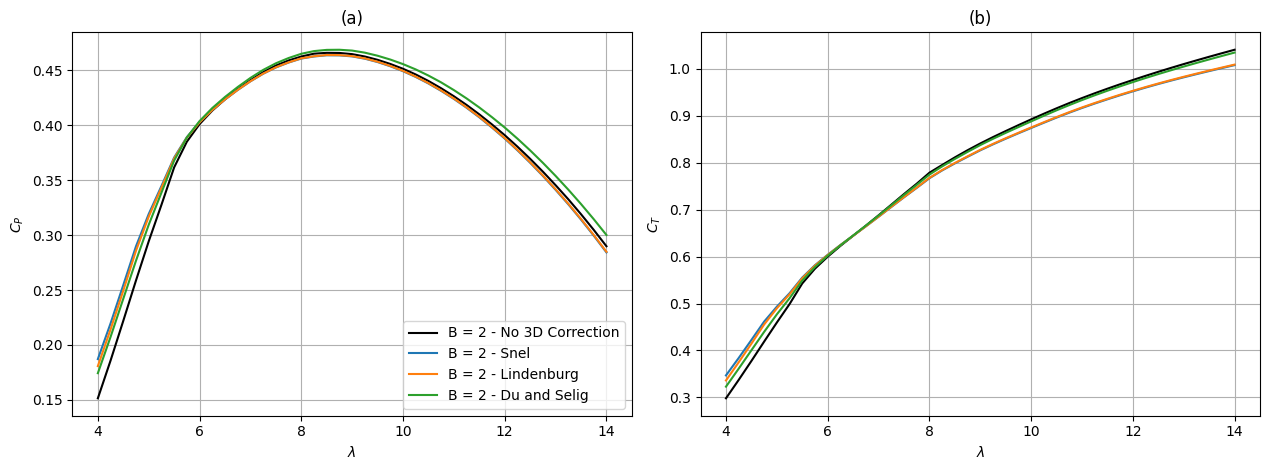

In [20]:
TSR = results_B2.TSR

CP_B2 = results_B2.CP
CT_B2 = results_B2.CT

CP_B2_3D_Snel = results_B2_3D_Snel.CP
CT_B2_3D_Snel = results_B2_3D_Snel.CT

CP_B2_3D_Lindenburg = results_B2_3D_Lindenburg.CP
CT_B2_3D_Lindenburg = results_B2_3D_Lindenburg.CT

CP_B2_3D_Du_and_Selig = results_B2_3D_Du_and_Selig.CP
CT_B2_3D_Du_and_Selig = results_B2_3D_Du_and_Selig.CT

fig = plt.figure(figsize=(12.8, 4.8))
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(TSR, CP_B2, 'k', label = 'B = 2 - No 3D Correction') 
ax1.plot(TSR, CP_B2_3D_Snel, label = 'B = 2 - Snel')
ax1.plot(TSR, CP_B2_3D_Lindenburg, label = 'B = 2 - Lindenburg')
ax1.plot(TSR, CP_B2_3D_Du_and_Selig, label = 'B = 2 - Du and Selig')

ax1.set_title('(a)')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$C_P$')
ax1.grid()
ax1.legend()


ax2.plot(TSR, CT_B2, 'k',  label = 'No 3D Correction') 
ax2.plot(TSR, CT_B2_3D_Snel, label = 'Snel')
ax2.plot(TSR, CT_B2_3D_Lindenburg, label = 'Lindenburg')
ax2.plot(TSR, CT_B2_3D_Du_and_Selig, label = 'Du and Selig')

ax2.set_title('(b)')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$C_T$')
ax2.grid()
# ax2.legend()

plt.tight_layout()
if save_images:
    fig.savefig(image_path.joinpath('effect_of_3D_correction_on_B2.eps'), format = 'eps', dpi = dpi)
plt.show()

### 2.6 Effect of hub correction

In [31]:
results_B2_hub = bemt(rotor=rotor_B2, TSR=np.arange(4, 14.25, 0.25), tip_correction_model='Prandtl',
                  iter=250, tol=1e-3, display=True, damping_factor=0.05,
                  initial_guess=(rotor_B2.sections['a'].to_numpy()[1:-1], rotor_B2.sections['a_line'].to_numpy()[1:-1]), 
                  hub_correction=True, rhub_R=0.1)


TSR: 4.0
-> Iteration: 132, Converged: True
TSR: 4.25
-> Iteration: 134, Converged: True
TSR: 4.5
-> Iteration: 144, Converged: True
TSR: 4.75
-> Iteration: 148, Converged: True
TSR: 5.0
-> Iteration: 150, Converged: True
TSR: 5.25
-> Iteration: 187, Converged: True
TSR: 5.5
-> Iteration: 129, Converged: True
TSR: 5.75
-> Iteration: 115, Converged: True
TSR: 6.0
-> Iteration: 112, Converged: True
TSR: 6.25
-> Iteration: 109, Converged: True
TSR: 6.5
-> Iteration: 108, Converged: True
TSR: 6.75
-> Iteration: 107, Converged: True
TSR: 7.0
-> Iteration: 105, Converged: True
TSR: 7.25
-> Iteration: 101, Converged: True
TSR: 7.5
-> Iteration: 92, Converged: True
TSR: 7.75
-> Iteration: 79, Converged: True
TSR: 8.0
-> Iteration: 54, Converged: True
TSR: 8.25
-> Iteration: 52, Converged: True
TSR: 8.5
-> Iteration: 68, Converged: True
TSR: 8.75
-> Iteration: 82, Converged: True
TSR: 9.0
-> Iteration: 92, Converged: True
TSR: 9.25
-> Iteration: 99, Converged: True
TSR: 9.5
-> Iteration: 105, C

c:\Users\Widmark Cardoso\Documents\github\BEMT\src\utils.py:41: RuntimeWarning: invalid value encountered in arccos
  F_tip = 2/np.pi * np.arccos(np.exp(-f))
c:\Users\Widmark Cardoso\Documents\github\BEMT\src\utils.py:48: RuntimeWarning: invalid value encountered in arccos
  F_hub = 2/np.pi * np.arccos(np.exp(f))


-> Iteration: 249, Converged: False
TSR: 13.25
-> Iteration: 215, Converged: True
TSR: 13.5
-> Iteration: 222, Converged: True
TSR: 13.75
-> Iteration: 224, Converged: True
TSR: 14.0
-> Iteration: 249, Converged: False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


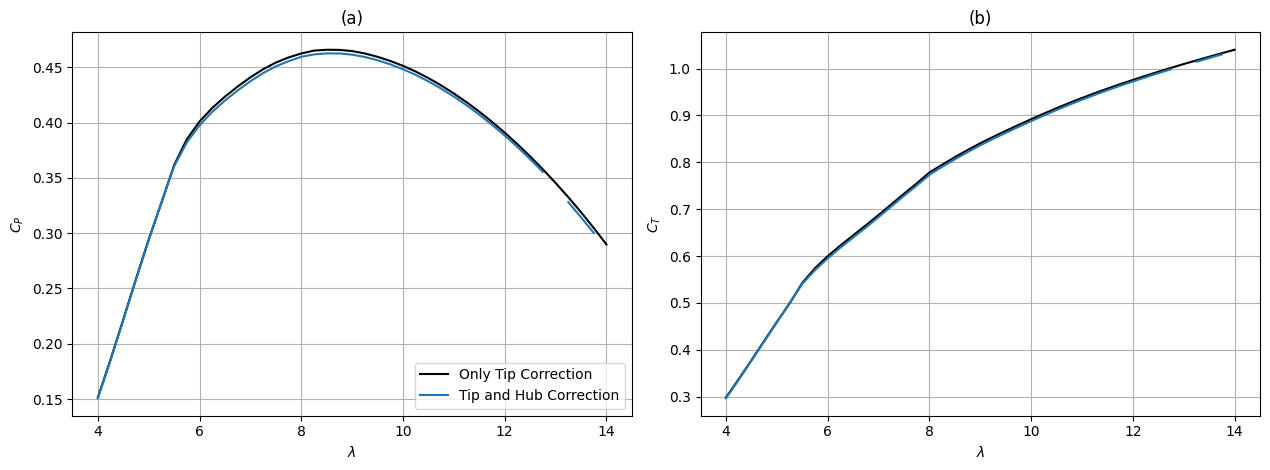

In [22]:
TSR = results_B2.TSR

CP_B2 = results_B2.CP
CT_B2 = results_B2.CT

CP_B2_hub = results_B2_hub.CP
CT_B2_hub = results_B2_hub.CT


fig = plt.figure(figsize=(12.8, 4.8))
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(TSR, CP_B2, 'k', label = 'Only Tip Correction') 
ax1.plot(TSR, CP_B2_hub, label = 'Tip and Hub Correction')


ax1.set_title('(a)')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$C_P$')
ax1.grid()
ax1.legend()


ax2.plot(TSR, CT_B2, 'k',  label = 'Only Tip Correction') 
ax2.plot(TSR, CT_B2_hub, label = 'Tip and Hub Correction')

ax2.set_title('(b)')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$C_T$')
ax2.grid()
# ax2.legend()

plt.tight_layout()
if save_images:
    fig.savefig(image_path.joinpath('effect_of_hub_correction_on_B2.eps'), format = 'eps', dpi = dpi)
plt.show()